# Multiple Choice QA on QUAIL dataset 🐦

In [ ]:
# !pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl

In [ ]:
!nvidia-smi

Sun Mar 13 23:27:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
## Standard libraries
import os
import json
import math
import numpy as np
import time
import pandas as pd
from google.colab import drive

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
# PyTorch Lightning
try:
    
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
try:
  from datasets import load_dataset
except ModuleNotFoundError:
  !pip install --quiet datasets
  from datasets import load_dataset

try:
  import spacy
except ModuleNotFoundError:
  !pip install --quiet spacy
  import spacy

import re
import string
from collections import Counter
import torchmetrics

try:
  from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
  from transformers import AutoModelWithHeads
except ModuleNotFoundError:
  !pip install --quiet -U adapter-transformers
  from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
  from transformers import AutoModelWithHeads

In [ ]:
drive.mount('/drive')
%cd '/drive/MyDrive/qa_analysis'

Mounted at /drive
/drive/MyDrive/qa_analysis


## QUAIL dataset preprocessing

In [ ]:
PREPROCESS = True

For LSTM model the input needs to be tokenized. 

In [ ]:
tok = spacy.load('en')
def tokenize (text):
    #remove non ascii values
    text = re.sub(r"[^\x00-\x7F]+", " ", text)
    # remove punctuation and numbers
    # define a pattern that detects all numbers and punctuation 
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
    # number and punct are substituted by space
    nopunct = regex.sub(" ", text.lower())
    #result is fed into spacy to tokenize sentence into tokens
    return [token.text for token in tok.tokenizer(nopunct)]

In [ ]:
def encode_sentence(text, vocab2index, N=70):
    tokenized = tokenize(text)
    encoded = np.zeros(N, dtype=int)
    enc1 = np.array([vocab2index.get(word, vocab2index["UNK"]) for word in tokenized])
    length = min(N, len(enc1))
    encoded[:length] = enc1[:length]
    return encoded, length

In [ ]:
dataset = load_dataset("quail")

Downloading:   0%|          | 0.00/1.97k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.34k [00:00<?, ?B/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/221k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/52.6k [00:00<?, ?B/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset quail downloaded and prepared to /root/.cache/huggingface/datasets/quail/quail/1.3.0/3cabab19c99e571b528209e14313cfff1debf772db9e24e19b4fcbeb8399336c. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
dataset['train']
# answers go from 0 - 3

Dataset({
    features: ['id', 'context_id', 'question_id', 'domain', 'metadata', 'context', 'question', 'question_type', 'answers', 'correct_answer_id'],
    num_rows: 10246
})

In [ ]:
ds_train = dataset['train']
ds_valid = dataset['validation']
ds_test = dataset['challenge']

### LSTM dataset and datamodule

In [ ]:
#preparing dataset
class QuailDataset(Dataset):
  def __init__(
    self,
    data: pd.DataFrame
  ):
    self.data = data

  def __len__(self):
    return len(self.data)
  
  def __getitem__(self, index: int):
    text = self.data['encoded_text']
    label = self.data['correct']

    return torch.from_numpy(text[index][0].astype(np.int32)), label[index], text[index][1]

In [ ]:
class QuailDataset2(Dataset):
  def __init__(
    self,
    data: pd.DataFrame
  ):
    self.data = data

  def __len__(self):
    return len(self.data)
  
  def __getitem__(self, index: int):
    answer = self.data['encoded_answer']
    question = self.data['encoded_question']
    context = self.data['encoded_context']
    label = self.data['correct']

    return torch.from_numpy(question[index][0].astype(np.int32)), question[index][1], torch.from_numpy(context[index][0].astype(np.int32)), context[index][1], torch.from_numpy(answer[index][0].astype(np.int32)), answer[index][1], label[index]

In [ ]:
class QuailDataModule(pl.LightningDataModule):
  def __init__(self, train_df, val_df, test_df, batch_size=8, num_workers=2):
    super().__init__()
    self.batch_size = batch_size
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df
    self.num_workers = num_workers

  def setup(self, stage=None):
    self.train_ds = QuailDataset(self.train_df)
    self.valid_ds = QuailDataset(self.val_df)
    self.test_ds = QuailDataset(self.test_df)
  
  def train_dataloader(self):
    return DataLoader(self.train_ds, shuffle=False, num_workers=self.num_workers, batch_size=self.batch_size)

  def val_dataloader(self):
    return DataLoader(self.valid_ds, shuffle=False, num_workers=self.num_workers, batch_size=self.batch_size)

  def test_dataloader(self):
    return DataLoader(self.test_ds, shuffle=False, num_workers=self.num_workers, batch_size=self.batch_size)

In [ ]:
class QuailDataModule2(pl.LightningDataModule):
  def __init__(self, train_df, val_df, test_df, batch_size=8, num_workers=2):
    super().__init__()
    self.batch_size = batch_size
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df
    self.num_workers = num_workers

  def setup(self, stage=None):
    self.train_ds = QuailDataset2(self.train_df)
    self.valid_ds = QuailDataset2(self.val_df)
    self.test_ds = QuailDataset2(self.test_df)
  
  def train_dataloader(self):
    return DataLoader(self.train_ds, shuffle=False, num_workers=self.num_workers, batch_size=self.batch_size)

  def val_dataloader(self):
    return DataLoader(self.valid_ds, shuffle=False, num_workers=self.num_workers, batch_size=self.batch_size)

  def test_dataloader(self):
    return DataLoader(self.test_ds, shuffle=False, num_workers=self.num_workers, batch_size=self.batch_size)

### Converting from huggingface dataset to pandas df

TODO: refactor code to use input a huggingface dataset instead

The input Question, Context, A1, A2, A3, A4, correct are splitted from a single vector into 4 different vectors. This is because the model's task will be a binary classification task to predict if given the question + context + answer(*) there is enough information to give an answer

In [ ]:
def dataset_to_pandas(dataset):
  list_data = []
  for data in dataset:
    for index, answer in enumerate(data['answers']):
      row = {'id': data['id'], 'question': data['question'], 'context': data['context'], 'answer': answer, 'correct': 0}
      if index == data['correct_answer_id']:
        row['correct'] = 1
      list_data.append(row)

  return pd.DataFrame(list_data)

In [ ]:
def dataset_to_pandas_balanced(dataset):
  list_data = []
  for data in dataset:
    flag = 0
    for index, answer in enumerate(data['answers']):
      row = {'id': data['id'], 'question': data['question'], 'context': data['context'], 'answer': answer, 'correct': 0}
      if index == data['correct_answer_id']:
        row['correct'] = 1
        list_data.append(row)

      if index != data['correct_answer_id'] and flag == 0:
        flag = 1 
        list_data.append(row)

  return pd.DataFrame(list_data)

In [ ]:
def dataset_to_pandas_single_row(dataset):
  list_data = []
  for data in dataset:
    row = {'id': data['id'], 'question': data['question'], 'context': data['context'], 'correct': data['correct_answer_id']}
    for index, answer in enumerate(data['answers']):
      row[f'answer_{index}']=answer
    list_data.append(row)
  return pd.DataFrame(list_data)

In [ ]:
df_train = dataset_to_pandas(ds_train)
df_valid = dataset_to_pandas(ds_valid)
df_test = dataset_to_pandas_balanced(ds_test)

In [ ]:
df_test_original = dataset_to_pandas(ds_test)

In [ ]:
df_test_mc = dataset_to_pandas_single_row(ds_test)

The input is concatenated to feed it into BERT. Because BERT's max input length is 512 and there are some texts longer we will concatenate the context at the end sacrificing some of the context. 

I'm using only one [SEP] token because BERT was trained on next sentence prediction. 

TODO: test if two [SEP] has an effect or not. 

In [ ]:
def concatenate_input(df_data):
  # df_data['text'] = df_data['question'] + '[SEP]' + df_data['answer'] + '[SEP]' + df_data['context']
  df_data['text'] = df_data['question'] + ' ' + df_data['answer'] + '[SEP]' + df_data['context']

concatenate_input(df_train)
concatenate_input(df_valid)
concatenate_input(df_test)
concatenate_input(df_test_original)

For LSTM we need to have a dictionary of all the tokens in the train dataset (bag of words). The max length of token dict will be used for the LSTM embedding layer. Because embedding layer may be too big some prunning is required.

In [ ]:
# # create dictionary

# def count_tokens(counts, df_list):
#   for df_data in df_list:
#     for index, row in df_data.iterrows():
#       #adds word tokens to unique set
#       counts.update(tokenize(row['text']))

# counts = Counter()
# count_tokens(counts, [df_train])

# #deleting infrequent words
# print("num_words before:",len(counts.keys()))
# for word in list(counts):
#     if counts[word] < 2:
#         del counts[word]
# print("num_words after:",len(counts.keys()))

# vocab2index = {"":0, "UNK":1}
# words = ["", "UNK"]
# for word in counts:
#     vocab2index[word] = len(words)
#     words.append(word)

In [ ]:
def transform_dataframe(df_data):
  #encoding each item
  df_train['encoded_question'] = df_train['question'].apply(lambda x: np.array(encode_sentence(x,vocab2index )))
  df_train['encoded_context'] = df_train['context'].apply(lambda x: np.array(encode_sentence(x,vocab2index )))
  df_train['encoded_answer'] = df_train['answer'].apply(lambda x: np.array(encode_sentence(x,vocab2index )))

  df_data['encoded_text'] = df_data['text'].apply(lambda x: np.array(encode_sentence(x,vocab2index, 512)))

In [ ]:
def transform_dataframe_single_row(df_data):
  df_data['text_0'] = df_data['question'] + ' ' + df_data['context'] + ' ' + df_data['answer_0']
  df_data['text_1'] = df_data['question'] + ' ' + df_data['context'] + ' ' + df_data['answer_1']
  df_data['text_2'] = df_data['question'] + ' ' + df_data['context'] + ' ' + df_data['answer_2']
  df_data['text_3'] = df_data['question'] + ' ' + df_data['context'] + ' ' + df_data['answer_3']

In [ ]:
# transform_dataframe(df_train)
# transform_dataframe(df_valid)
# transform_dataframe(df_test)
# transform_dataframe(df_test_original)

In [ ]:
# transform_dataframe_single_row(df_test_mc)

In [ ]:
# df_train['text'] = df_train['text'].apply(lambda x: clean_dataframe(x))
# df_valid['text'] = df_valid['text'].apply(lambda x: clean_dataframe(x))
# df_test['text'] = df_test['text'].apply(lambda x: clean_dataframe(x))

## LSTM baseline

### Learning LSTM

In [ ]:
# class LSTM(pl.LightningModule):
#   def __init__(self):
#     super().__init__()
#     vocab_size = len(vocab2index)
#     embedding_dim = 8
#     hidden_dim = 50
#     self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
#     self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
#     self.fc1 = nn.Linear(hidden_dim, hidden_dim)
#     self.fc2 = nn.Linear(hidden_dim, 1)
#     # self.dropout = nn.Dropout(0.2)
#     self.criterion = nn.BCELoss()
#     self.sig = nn.Sigmoid()

#     self.train_acc = torchmetrics.Accuracy()
#     self.valid_acc = torchmetrics.Accuracy()
#     self.test_acc = torchmetrics.Accuracy()

#   def forward(self, input):
#     x = self.embeddings(input)
#     # x = self.dropout(x)
#     lstm_out, (ht, ct) = self.lstm(x)
#     x = F.relu(self.fc1(ht[-1]))
#     return self.sig(self.fc2(x))

#   def training_step(self, batch, batch_idx):
#     x, y, z = batch
#     y = y.view(len(y), 1)
#     y_pred = self(x)
#     loss = self.criterion(y_pred, y.float())
#     self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
#     self.train_acc(y_pred, y)
#     self.log('train_acc', self.train_acc, on_step=True, on_epoch=True)
#     return loss



#   def validation_step(self, batch, batch_idx):
#     x, y, z = batch
#     y = y.view(len(y), 1)
#     y_pred = self(x)
#     # print(f'y_data {y}')
#     # print(f'y_pred {y_pred}')
#     # print(f'y_pred_shape {y_pred.shape}')
#     loss = self.criterion(y_pred, y.float())
#     self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
#     self.valid_acc(y_pred, y)
#     self.log('val_acc', self.valid_acc, on_step=True, on_epoch=True)
#     return loss

#   def test_step(self, batch, batch_idx):
#     x, y, z = batch
#     y = y.view(len(y), 1)
#     y_pred = self(x)
#     loss = self.criterion(y_pred, y.float())
#     self.log("test_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
#     self.test_acc(y_pred, y)
#     self.log('test_acc', self.test_acc, on_step=True, on_epoch=True)
    
#     return loss 

#   def configure_optimizers(self):
#     return optim.Adam(self.parameters(), lr=0.001)

In [ ]:
# dm = QuailDataModule(df_train, df_valid, df_test)
# model = LSTM()

In [ ]:
# early_stop_callback = EarlyStopping(monitor="val_loss", patience = 5, verbose=False, mode="max")
# checkpoint_callback = ModelCheckpoint(
#   dirpath="checkpointsv1",
#   filename="best-checkpoint",
#   save_top_k=1,
#   verbose=True,
#   monitor="val_loss",
#   mode="min"
# )

# trainer = pl.Trainer(max_epochs=30, gpus=1, callbacks=[early_stop_callback])
# trainer.fit(model, dm)

In [ ]:
# trainer.test(datamodule=dm)

In [ ]:
# model = LSTM.load_from_checkpoint(
#   '/drive/MyDrive/qa_analysis/lightning_logs/version_72/checkpoints/epoch=29-step=307379.ckpt'
# )
# model.eval()
# model.freeze()

### Bigger baseline

In [ ]:
# class LSTM(pl.LightningModule):
#   def __init__(self):
#     super().__init__()
#     vocab_size = len(vocab2index)
#     embedding_dim = 400
#     hidden_dim = 256
#     self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
#     self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
#     self.fc1 = nn.Linear(hidden_dim, hidden_dim)
#     self.fc2 = nn.Linear(hidden_dim, 1)
#     self.dropout = nn.Dropout(0.2)
#     self.criterion = nn.BCELoss()
#     self.sig = nn.Sigmoid()

#     self.train_acc = torchmetrics.Accuracy()
#     self.valid_acc = torchmetrics.Accuracy()
#     self.test_acc = torchmetrics.Accuracy()

#   def forward(self, input):
#     x = self.embeddings(input)
#     # x = self.dropout(x)
#     lstm_out, (ht, ct) = self.lstm(x)
#     # x = F.relu(self.fc1(ht[-1]))
#     x = self.dropout(ht[-1])
#     # ht [-1] to remove extra dimension containing one list
#     return self.sig(self.fc2(x))

#   def training_step(self, batch, batch_idx):
#     x, y, z = batch
#     y = y.view(len(y), 1)
#     y_pred = self(x)
#     loss = self.criterion(y_pred, y.float())
#     self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
#     self.train_acc(y_pred, y)
#     self.log('train_acc', self.train_acc, on_step=True, on_epoch=True)
#     return loss



#   def validation_step(self, batch, batch_idx):
#     x, y, z = batch
#     y = y.view(len(y), 1)
#     y_pred = self(x)
#     loss = self.criterion(y_pred, y.float())
#     self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
#     self.valid_acc(y_pred, y)
#     self.log('val_acc', self.valid_acc, on_step=True, on_epoch=True)
#     return loss

#   def test_step(self, batch, batch_idx):
#     x, y, z = batch
#     y = y.view(len(y), 1)
#     y_pred = self(x)
#     loss = self.criterion(y_pred, y.float())
#     self.log("test_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
#     self.test_acc(y_pred, y)
#     self.log('test_acc', self.test_acc, on_step=True, on_epoch=True)
    
#     return loss 

#   def configure_optimizers(self):
#     return optim.Adam(self.parameters(), lr=0.001)

In [ ]:
# class LSTM(pl.LightningModule):
#   def __init__(self):
#     super().__init__()
#     vocab_size = len(vocab2index)
#     embedding_dim = 400
#     hidden_dim = 256
#     self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
#     self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
#     self.fc1 = nn.Linear(hidden_dim, hidden_dim)
#     self.fc2 = nn.Linear(hidden_dim, 1)
#     self.dropout = nn.Dropout(0.2)
#     self.criterion = nn.BCELoss()
#     self.sig = nn.Sigmoid()

#     self.train_acc = torchmetrics.Accuracy()
#     self.valid_acc = torchmetrics.Accuracy()
#     self.test_acc = torchmetrics.Accuracy()

#   def forward(self, input, z):
#     x = self.embeddings(input)
#     # x = self.dropout(x)
#     x = pack_padded_sequence(x, z.cpu(), batch_first=True, enforce_sorted=False)
#     x, (ht, ct) = self.lstm(x)
#     x, output_lengths = pad_packed_sequence(x, batch_first=True)
#     x = x[:, -1, :]
#     # x = F.relu(self.fc1(ht[-1]))
#     x = self.dropout(x)
#     # ht [-1] to remove extra dimension containing one list
#     return self.sig(self.fc2(x))

#   def training_step(self, batch, batch_idx):
#     x, y, z = batch
#     y = y.view(len(y), 1)
#     y_pred = self(x, z)
#     loss = self.criterion(y_pred, y.float())
#     self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
#     self.train_acc(y_pred, y)
#     self.log('train_acc', self.train_acc, on_step=True, on_epoch=True)
#     return loss

#   def validation_step(self, batch, batch_idx):
#     x, y, z = batch
#     y = y.view(len(y), 1)
#     y_pred = self(x, z)
#     loss = self.criterion(y_pred, y.float())
#     self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
#     self.valid_acc(y_pred, y)
#     self.log('val_acc', self.valid_acc, on_step=True, on_epoch=True)
#     return loss

#   def test_step(self, batch, batch_idx):
#     x, y, z = batch
#     y = y.view(len(y), 1)
#     y_pred = self(x, z)
#     loss = self.criterion(y_pred, y.float())
#     self.log("test_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
#     self.test_acc(y_pred, y)
#     self.log('test_acc', self.test_acc, on_step=True, on_epoch=True)
    
#     return loss 

#   def configure_optimizers(self):
#     return optim.Adam(self.parameters(), lr=0.001)

In [ ]:
# class LSTM(pl.LightningModule):
#   def __init__(self):
#     super().__init__()
#     vocab_size = len(vocab2index)
#     embedding_dim = 400
#     hidden_dim = 256
#     self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
#     self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2, batch_first=True, bidirectional = True, num_layers = 2)
#     self.fc1 = nn.Linear(hidden_dim, hidden_dim)
#     self.fc2 = nn.Linear(hidden_dim, 1)
#     self.dropout = nn.Dropout(0.2)
#     self.criterion = nn.BCELoss()
#     self.sig = nn.Sigmoid()

#     self.train_acc = torchmetrics.Accuracy()
#     self.valid_acc = torchmetrics.Accuracy()
#     self.test_acc = torchmetrics.Accuracy()

#   def forward(self, input, z):
#     x = self.embeddings(input)
#     # x = self.dropout(x)
#     x = pack_padded_sequence(x, z.cpu(), batch_first=True, enforce_sorted=False)
#     x, (ht, ct) = self.lstm(x)
#     x, output_lengths = pad_packed_sequence(x, batch_first=True)
#     x = x[:, -1, :]
#     # x = F.relu(self.fc1(ht[-1]))
#     x = self.dropout(x)
#     # ht [-1] to remove extra dimension containing one list
#     return self.sig(self.fc2(x))

#   def training_step(self, batch, batch_idx):
#     x, y, z = batch
#     y = y.view(len(y), 1)
#     y_pred = self(x, z)
#     loss = self.criterion(y_pred, y.float())
#     self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
#     self.train_acc(y_pred, y)
#     self.log('train_acc', self.train_acc, on_step=True, on_epoch=True)
#     return loss

#   def validation_step(self, batch, batch_idx):
#     x, y, z = batch
#     y = y.view(len(y), 1)
#     y_pred = self(x, z)
#     loss = self.criterion(y_pred, y.float())
#     self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
#     self.valid_acc(y_pred, y)
#     self.log('val_acc', self.valid_acc, on_step=True, on_epoch=True)
#     return loss

#   def test_step(self, batch, batch_idx):
#     x, y, z = batch
#     y = y.view(len(y), 1)
#     y_pred = self(x, z)
#     loss = self.criterion(y_pred, y.float())
#     self.log("test_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
#     self.test_acc(y_pred, y)
#     self.log('test_acc', self.test_acc, on_step=True, on_epoch=True)
    
#     return loss 

#   def configure_optimizers(self):
#     return optim.Adam(self.parameters(), lr=0.001)

In [ ]:
# class LSTM(pl.LightningModule):
#   def __init__(self, learning_rate):
#     super().__init__()
#     self.learning_rate = learning_rate
#     vocab_size = len(vocab2index)
#     embedding_dim = 100
#     hidden_dim = 128
#     self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
#     self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional = True, num_layers = 2)
#     self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
#     self.fc2 = nn.Linear(hidden_dim, 1)
#     self.dropout = nn.Dropout(0.2)
#     self.criterion = nn.BCELoss()
#     self.sig = nn.Sigmoid()

#     self.train_acc = torchmetrics.Accuracy()
#     self.valid_acc = torchmetrics.Accuracy()
#     self.test_acc = torchmetrics.Accuracy()

#   def forward(self, input, z):
#     x = self.embeddings(input)
#     # x = self.dropout(x)
#     x = pack_padded_sequence(x, z.cpu(), batch_first=True, enforce_sorted=False)
#     x, (ht, ct) = self.lstm(x)
#     x, output_lengths = pad_packed_sequence(x, batch_first=True)
#     x = x[:, -1, :]
#     x = F.relu(self.fc1(x))
#     x = self.dropout(x)
#     # ht [-1] to remove extra dimension containing one list
#     return self.sig(self.fc2(x))

#   def training_step(self, batch, batch_idx):
#     x, y, z = batch
#     y = y.view(len(y), 1)
#     y_pred = self(x, z)
#     loss = self.criterion(y_pred, y.float())
#     self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
#     self.train_acc(y_pred, y)
#     self.log('train_acc', self.train_acc, on_step=True, on_epoch=True)
#     return loss

#   def validation_step(self, batch, batch_idx):
#     x, y, z = batch
#     y = y.view(len(y), 1)
#     y_pred = self(x, z)
#     loss = self.criterion(y_pred, y.float())
#     self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
#     self.valid_acc(y_pred, y)
#     self.log('val_acc', self.valid_acc, on_step=True, on_epoch=True)
#     return loss

#   def test_step(self, batch, batch_idx):
#     x, y, z = batch
#     y = y.view(len(y), 1)
#     y_pred = self(x, z)
#     loss = self.criterion(y_pred, y.float())
#     self.log("test_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
#     self.test_acc(y_pred, y)
#     self.log('test_acc', self.test_acc, on_step=True, on_epoch=True)
    
#     return loss 

#   def configure_optimizers(self):
#     return optim.Adam(self.parameters(), lr=self.learning_rate)

In [ ]:
# dm = QuailDataModule(df_train, df_valid, df_test, 64, 4)

In [ ]:
# model = LSTM(0.0001)

In [ ]:
# early_stop_callback = EarlyStopping(monitor="val_loss_epoch", patience = 10, verbose=False, mode="min")
# checkpoint_callback = ModelCheckpoint(
#   # dirpath="checkpointsv1",
#   # filename="best-checkpoint",
#   save_top_k=1,
#   verbose=True,
#   monitor="val_loss_epoch",
#   mode="min"
# )

# trainer = pl.Trainer(max_epochs=100, gpus=1, callbacks=[early_stop_callback, checkpoint_callback], auto_lr_find=True)

In [ ]:
# trainer.tune(model, dm)

In [ ]:
# trainer.fit(model, dm)

In [ ]:
# trainer.test(model, datamodule=dm)

## Let's use BERT 😠

Ok so LSTM didn't work maybe more advanced language model perform better.

In [ ]:
BERT_MODEL_NAME = 'bert-base-uncased'

In [ ]:
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
token_counts = []
big_texts = []
for _, row in df_train.iterrows():
  token_count = len(tokenizer.encode(
    row["text"],
    max_length=512,
    truncation=True
  ))
  token_counts.append(token_count)

  if token_count == 512:
    big_texts.append(row['text'])

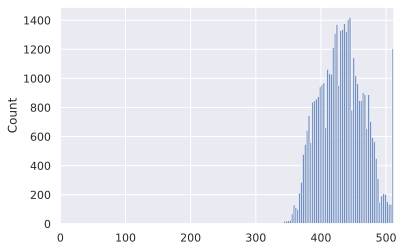

In [ ]:
sns.histplot(token_counts)
plt.xlim([0, 512]);

In [ ]:
string = '         86     [SEP]        apple peach'
out = tokenizer.encode_plus(string, max_length=512, truncation=True)
print(out)
print(tokenizer.convert_ids_to_tokens(out["input_ids"])[:20])

{'input_ids': [101, 6564, 102, 6207, 18237, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1]}
['[CLS]', '86', '[SEP]', 'apple', 'peach', '[SEP]']


In [ ]:
out = tokenizer.encode_plus(big_texts[0], max_length=512, truncation=True)
print(out)
print(tokenizer.convert_ids_to_tokens(out["input_ids"]))

{'input_ids': [101, 2040, 2106, 1996, 3166, 6235, 2004, 1000, 1037, 2210, 4689, 1029, 1000, 1024, 9246, 102, 2258, 1015, 1010, 2294, 4787, 2351, 2651, 1012, 2179, 2041, 2023, 2851, 2058, 6350, 1012, 5920, 1012, 4787, 1012, 1045, 1005, 1049, 2145, 2667, 2000, 10236, 2026, 2568, 2105, 2009, 1012, 5920, 1012, 4787, 2347, 1005, 1056, 26094, 1012, 1045, 2113, 2008, 1010, 2113, 2009, 2005, 1037, 2755, 1012, 2021, 2002, 2003, 2757, 1012, 2339, 1029, 1045, 2572, 2025, 13219, 2438, 2000, 8343, 1000, 12487, 2377, 1000, 2004, 2027, 2360, 1999, 1996, 6547, 3441, 1012, 2053, 2028, 14977, 2438, 2055, 1037, 2451, 2267, 2396, 3836, 2000, 4028, 2032, 1012, 2021, 5920, 1029, 2242, 2003, 3308, 2182, 1012, 2200, 3308, 1012, 2258, 1016, 1010, 2294, 1045, 2134, 1005, 1056, 5382, 2127, 2023, 2851, 2008, 7483, 2001, 2258, 18656, 2154, 1012, 2070, 2785, 1997, 5305, 8257, 1029, 2021, 2008, 1005, 1055, 2025, 2066, 4787, 2593, 1012, 2002, 2001, 1037, 2210, 4689, 1010, 2021, 2025, 2008, 2785, 1997, 4689, 1012, 214

### BERT Dataset and Dataloader

QUAIL paper uses 400 input length. I'm trying with 512 to try to minimize the lost of context.

In [ ]:
MAX_TOKEN_COUNT = 512
# MAX_TOKEN_COUNT = 400

In [ ]:
class BERTDataset(Dataset):
  def __init__(self, data, tokenizer, max_token_len):
    self.tokenizer = tokenizer
    self.data = data
    self.max_token_len = max_token_len

  def __len__(self):
    return len(self.data)
  
  def __getitem__(self, index: int):
    data_row = self.data.iloc[index]

    #text to get encoded
    comment_text = data_row.text 
    
    #labels used for the text
    labels = data_row.correct
    
    #encoder
    encoding = self.tokenizer.encode_plus(
      comment_text,
      add_special_tokens=True,
      max_length=self.max_token_len,
      return_token_type_ids=False,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return dict(
      comment_text=comment_text,
      input_ids=encoding["input_ids"].flatten(),
      attention_mask=encoding["attention_mask"].flatten(),
      labels = labels
    )

In [ ]:
train_dataset = BERTDataset(
      df_train,
      tokenizer,
      MAX_TOKEN_COUNT
    )

In [ ]:
loader = DataLoader(
      train_dataset,
      batch_size=4,
      shuffle=True,
      num_workers=2
    )

In [ ]:
bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
classifier = nn.Linear(bert.config.hidden_size, 1)
sig = nn.Sigmoid()
criterion = nn.BCELoss()

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
for data in loader:
  # print(data)
  comments = data['comment_text']
  input_ids = data["input_ids"]
  attention_mask = data["attention_mask"]
  labels = data["labels"]
  labels = labels.view(len(labels), 1)
  print(input_ids[0].shape)
  print(input_ids[1].shape)
  output = bert(input_ids, attention_mask=attention_mask)
  output = classifier(output.pooler_output)
  print(output.shape)
  print(output)
  output = torch.sigmoid(output)
  out = criterion(output, labels.float())
  print(out)
  break

torch.Size([512])
torch.Size([512])
torch.Size([4, 1])
tensor([[0.1685],
        [0.1275],
        [0.1423],
        [0.1237]], grad_fn=<AddmmBackward0>)
tensor(0.7238, grad_fn=<BinaryCrossEntropyBackward0>)


In [ ]:
class BERTDataModule(pl.LightningDataModule):
  def __init__(self, train_df, val_df, test_df, tokenizer, batch_size, max_token_len):
    super().__init__()
    self.batch_size = batch_size
    self.train_df = train_df
    self.test_df = test_df
    self.val_df = val_df
    self.tokenizer = tokenizer
    self.max_token_len = max_token_len

  def setup(self, stage=None):
    self.train_dataset = BERTDataset(
      self.train_df,
      self.tokenizer,
      self.max_token_len
    )

    self.val_dataset = BERTDataset(
      self.test_df,
      self.tokenizer,
      self.max_token_len
    )

    self.test_dataset = BERTDataset(
      self.test_df,
      self.tokenizer,
      self.max_token_len
    )

  def train_dataloader(self):
    return DataLoader(
      self.train_dataset,
      batch_size=self.batch_size,
      shuffle=True,
      num_workers=4,
      drop_last = True
    )

  def val_dataloader(self):
    return DataLoader(
      self.val_dataset,
      batch_size=self.batch_size,
      num_workers=4,
      drop_last = True
    )
    
  def test_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=4,
      drop_last = True
    )

### BERT model

In [ ]:
BATCH_SIZE = 1
N_EPOCHS = 10

In [ ]:
class BERT(pl.LightningModule):
  def __init__(self, learning_rate, n_training_steps, n_warmup_steps):
    super().__init__()
    self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
    adapter_name = self.bert.load_adapter("AdapterHub/bert-base-uncased-pf-race", source="hf")
    self.bert.active_adapters = adapter_name
    self.fc1 = nn.Linear(self.bert.config.hidden_size, 1)
    # self.fc2 = nn.Linear(256, 64)
    # self.fc3 = nn.Linear(64, 16)
    # self.fc4 = nn.Linear(16, 1)
    self.dropout = nn.Dropout(0.2)
    self.learning_rate = learning_rate
    self.criterion = nn.BCEWithLogitsLoss()

    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps

  def forward(self, input_ids, attention_mask, labels=None):
    bert_output = self.bert(input_ids, attention_mask=attention_mask)
    x = bert_output.pooler_output
    # x = self.dropout(x)
    # x = F.relu(self.fc1(x))
    # x = F.relu(self.fc2(x))
    # x = F.relu(self.fc3(x))

    output = self.fc1(x)
    loss = 0
    if labels is not None:
        # labels = labels.view(len(labels), 1)
        loss = self.criterion(output.squeeze(-1), labels.float())
    return loss, output
  
  def training_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True, batch_size=BATCH_SIZE)
    return loss
  
  def validation_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True, batch_size=BATCH_SIZE)
    return loss
  
  def test_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("test_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True, batch_size=BATCH_SIZE)
    return loss
      
  def configure_optimizers(self):
    optimizer = AdamW(self.parameters(), lr=self.learning_rate)
    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=self.n_warmup_steps,
      num_training_steps=self.n_training_steps
    )
    return dict(
      optimizer=optimizer,
      lr_scheduler=dict(
        scheduler=scheduler,
        interval='step'
      )
    )


In [ ]:
data_module = BERTDataModule(
  df_train,
  df_valid,
  df_test,
  tokenizer,
  batch_size=BATCH_SIZE,
  max_token_len=MAX_TOKEN_COUNT
)

In [ ]:
steps_per_epoch=len(df_train) // BATCH_SIZE
print(steps_per_epoch)
total_training_steps = steps_per_epoch * N_EPOCHS
print(total_training_steps)
warmup_steps = total_training_steps // 5
print(warmup_steps)

40984
409840
81968


In [ ]:
model = BERT(learning_rate = 1e-5, n_training_steps = total_training_steps, n_warmup_steps = warmup_steps)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/573 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/379 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.59M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.37M [00:00<?, ?B/s]

In [ ]:
checkpoint_callback = ModelCheckpoint(
  save_top_k=1,
  verbose=True,
  monitor="val_loss",
  mode="min"
)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
trainer = pl.Trainer(
    callbacks=[early_stopping_callback, checkpoint_callback],
    max_epochs=10,
    gpus=1,
    auto_lr_find=True,
    accumulate_grad_batches=25
    # resume_from_checkpoint="/drive/MyDrive/qa_analysis/lightning_logs/version_173/checkpoints/epoch=8-step=23048.ckpt"
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
# trainer.tune(model, data_module)

In [ ]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | bert      | BertModel         | 110 M 
1 | fc1       | Linear            | 769   
2 | dropout   | Dropout           | 0     
3 | criterion | BCEWithLogitsLoss | 0     
------------------------------------------------
110 M     Trainable params
0         Non-trainable params
110 M     Total params
441.510   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch 0, global step 1639: val_loss reached 0.78999 (best 0.78999), saving model to "/drive/MyDrive/qa_analysis/lightning_logs/version_192/checkpoints/epoch=0-step=1639.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 1, global step 3279: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 2, global step 4919: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 3, global step 6559: val_loss was not in top 1


### Testing model

In [ ]:
# bert with adapter batch 8
# model = BERT.load_from_checkpoint(
#   '/drive/MyDrive/qa_analysis/lightning_logs/version_184/checkpoints/epoch=3-step=20491.ckpt',
#   learning_rate = 1e-5
# )

# bert batch 8
# model = BERT.load_from_checkpoint(
#   '/drive/MyDrive/qa_analysis/lightning_logs/version_181/checkpoints/epoch=1-step=10245.ckpt',
#   learning_rate = 1e-5
# )

# bert batch 25
# model = BERT.load_from_checkpoint(
#   '/drive/MyDrive/qa_analysis/lightning_logs/version_183/checkpoints/epoch=2-step=4919.ckpt',
#   learning_rate = 1e-5
# )

#bert with adapter batch 32
# model = BERT.load_from_checkpoint(
#   '/drive/MyDrive/qa_analysis/lightning_logs/version_185/checkpoints/epoch=3-step=5123.ckpt',
#   learning_rate = 1e-5
# )

#bert with adapter batch 16
# model = BERT.load_from_checkpoint(
#   '/drive/MyDrive/qa_analysis/lightning_logs/version_186/checkpoints/epoch=1-step=5121.ckpt',
#   learning_rate = 1e-5
# )

#bert with adapter batch 4
# model = BERT.load_from_checkpoint(
#   '/drive/MyDrive/qa_analysis/lightning_logs/version_187/checkpoints/epoch=2-step=30737.ckpt',
#   learning_rate = 1e-4
# )

#bert with adapter batch 8 only 1 <SEP>
# model = BERT.load_from_checkpoint(
#   '/drive/MyDrive/qa_analysis/lightning_logs/version_188/checkpoints/epoch=0-step=5122.ckpt',
#   learning_rate = 1e-5
# )

#bert with adapter batch 8 only 1 <SEP> with warmup
model = BERT.load_from_checkpoint(
  '/drive/MyDrive/qa_analysis/lightning_logs/version_190/checkpoints/epoch=2-step=15368.ckpt',
  learning_rate = 1e-5,
   n_training_steps = total_training_steps, n_warmup_steps = warmup_steps
)

#same as in paper
# model = BERT.load_from_checkpoint(
#   '/drive/MyDrive/qa_analysis/lightning_logs/version_192/checkpoints/epoch=0-step=1639.ckpt',
#   learning_rate = 1e-5,
#    n_training_steps = total_training_steps, n_warmup_steps = warmup_steps
# )

model.eval()
model.freeze()



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


#### Testing LSTM

In [ ]:
# model = LSTM.load_from_checkpoint(
#   '/drive/MyDrive/qa_analysis/lightning_logs/version_143/checkpoints/epoch=1-step=641.ckpt',
#   learning_rate = 0.0001
# )
# model.eval()
# model.freeze()

In [ ]:
# test_dataset = QuailDataset(df_test)
# loader_test = DataLoader(test_dataset, shuffle=False, num_workers=0, batch_size=4)

# predictions = []
# labels = []

# positive = 0
# negative = 0
# for item in loader_test:
  
#   pred = model(item[0], item[2])

#   predictions.append(pred.flatten())
#   labels.append(item[1].int())

#   max_prediction = torch.argmax(pred)
#   max_label = torch.argmax(item[1])

#   if torch.equal(max_prediction, max_label):
#     positive = positive + 1
#   else:
#     negative = negative + 1

# predictions = torch.stack(predictions).detach().cpu()
# labels = torch.stack(labels).detach().cpu()

#### For testing BERT

TODO: save hyperparameters on the logs and test integration with wandb hyperparameter sweep.

In [ ]:
#FOR BERT with challenge dataset

test_dataset = BERTDataset(df_test_original, tokenizer, 512)
loader_test = DataLoader(test_dataset, shuffle=False, num_workers=0, batch_size=4)

predictions = []
labels = [] 

positive = 0
negative = 0
it = 0
for item in loader_test:

  input_ids = item["input_ids"]
  attention_mask = item["attention_mask"]
  target = item["labels"]

  loss, outputs = model(input_ids, attention_mask)
  # print(outputs)
  prob = torch.sigmoid(outputs)
  # print(prob)
  # print(item['comment_text'][0])
  # print()
  # print(item['comment_text'][1])
  # print()
  # print(item['comment_text'][2])
  # print()
  # print(item['comment_text'][3])
  # print()
  # print(item["input_ids"].shape)
  # print(prob)
  predictions.append(prob.flatten())
  labels.append(target.int())

  max_prediction = torch.argmax(prob.flatten())
  max_label = torch.argmax(target)

  if torch.equal(max_prediction, max_label):
    # print(f'prediction {max_prediction} label {max_label}')
    positive = positive + 1
  else:
    negative = negative + 1

  # if it == 0:
  #   break
  # it = it + 1

predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()

In [ ]:
#FOR BERT with validation

val_dataset = BERTDataset(df_valid, tokenizer, 512)
loader_val = DataLoader(val_dataset, shuffle=False, num_workers=0, batch_size=4)

predictions = []
labels = [] 

positive = 0
negative = 0
it = 0
for item in loader_val:

  input_ids = item["input_ids"]
  attention_mask = item["attention_mask"]
  target = item["labels"]

  loss, outputs = model(input_ids, attention_mask)
  prob = torch.sigmoid(outputs)

  predictions.append(prob.flatten())
  labels.append(target.int())

  max_prediction = torch.argmax(prob.flatten())
  max_label = torch.argmax(target)

  if torch.equal(max_prediction, max_label):
    positive = positive + 1
  else:
    negative = negative + 1

predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()

In [ ]:
#real accuracy on the test using challenge dataset

positive / (positive + negative)

# paper got 37.2 -> vs me 25.7 small lstm
# -> bigger model 28.59 -> even bigger 29.49 (not predicting any positive at all (suss!!)
# -> with balanced train/val dataset -> damn 0.25 but higher true positive count :)
# -> with balanced without big fc -> 29.31
# -> with packed padding 29.49 (predicts positives !!)
# -> bilstm with fc1 30.93
# -> bert :( 29.49 confusion matrix only positives
# -> bert using more fc 29.49 confusion matrix only positives again
# -> bert uncased no preprocessing 5e-5 lr 29.49 only positives 
# -> bert uncased 5e-6 lr 29.49 only positives
# -> bert uncased 3e-5 lr 29.29 all negatives 
# -> bert changed input 5e-5 lr 30.57 all negative predictions
# -> bert changed input 1e-4 lr 28.05 all positives
# -> bert changed input 3e-5 lr 18.70 all positives

# bert loss stuck at 0.69315
# -> bert changed input 3e-5 lr 29.49 all negatives
# -> bert all input 3e-5 lr 22.48 all negatives

# -> bert with loss 1e-5 all data outputs with batch size 8 different probabilities omg !!! 39.92 acc
# -> wtf bert with loss 1e-5 all data with batch size 1 and accumulation 25 has 42.98 acc
# -> bert with RACE adapter 1e-5 loss all data with batch size 8 has 44.24 acc
# -> bert with RACE adapter 1e-5 loss all data with batch size 32 has 40.46 acc
# -> bert with RACE adapter 1e-5 loss all data with batch size 16 has 27.69 acc only predicting negatives
# -> bert with RACE adapter 1e-4 loss all data with batch size 4 has 29.85 acc only predictiing negatives
# -> bert with RACE adapter 1e-5 loss all data with batch size 8 only 1 sep 39.20 acc
# -> bert with RACE adapter 1e-5 loss all data with batch size 8 only 1 sep with warmup 43.16 acc
# -> bert with RACE adapter 1e-5 loss all data with batch size 25 only 1 sep with warmup 400d token length 23.02 acc

0.2302158273381295

In [ ]:
# from challenge dataset

torchmetrics.functional.classification.confusion_matrix(predictions, labels, num_classes=2)

# tensor([[1337,  331],
#         [ 418,  138]])

# TN FP
# FN TP

#with balanced dataset
# tensor([[795, 873],
#         [251, 305]])

#with bert
# tensor([[   0, 1668],
#         [   0,  556]])

#with all data negative imbalance
# tensor([[1668,    0],
#         [ 556,    0]])

# actually predicting some positives
# tensor([[1616,   52],
#         [ 500,   56]])

#with gradient accumulation
# tensor([[1445,  223],
#         [ 402,  154]])

#with RACE adapter
# tensor([[1357,  311],
#         [ 343,  213]])

# tensor([[1588,   80],
#         [ 501,   55]])

#bert with warmup batch 8
# tensor([[1550,  118],
#         [ 441,  115]])

tensor([[1668,    0],
        [ 556,    0]])

In [ ]:
#results from challenge dataset

from torchmetrics import AUROC, Precision, Recall, F1Score, Accuracy
auroc = AUROC(num_classes=1)
precision = Precision(num_classes=1)
recall = Recall(num_classes=1)
f1 = F1Score(num_classes=1)
accuracy = Accuracy()
print('AUROC: ')
print(auroc(predictions.flatten(), labels.flatten()))
print('Precision: ')
print(precision(predictions.flatten(), labels.flatten()))
print('Recall: ')
print(recall(predictions.flatten(), labels.flatten()))
print('F1: ')
print(f1(predictions.flatten(), labels.flatten()))
print('Accuracy:')
print(accuracy(predictions, labels))

# bert model batch 8
# AUROC: 
# tensor(0.6856)
# Precision: 
# tensor(0.5185)
# Recall: 
# tensor(0.1007)
# F1: 
# tensor(0.1687)
# Accuracy:
# tensor(0.7518)

# bert model batch 1 accumulation 25
# AUROC: 
# tensor(0.6860)
# Precision: 
# tensor(0.4085)
# Recall: 
# tensor(0.2770)
# F1: 
# tensor(0.3301)
# Accuracy:
# tensor(0.7190)

# bert model with RACE adapter with batch 8
# AUROC: 
# tensor(0.6901)
# Precision: 
# tensor(0.4065)
# Recall: 
# tensor(0.3831)
# F1: 
# tensor(0.3944)
# Accuracy:
# tensor(0.7059)

# bert model with RACE adapter with batch 32
# AUROC: 
# tensor(0.6992)
# Precision: 
# tensor(0.4759)
# Recall: 
# tensor(0.1601)
# F1: 
# tensor(0.2396)
# Accuracy:
# tensor(0.7460)

# bert model with RACE adapter with batch 16
# AUROC: 
# tensor(0.5824)
# Precision: 
# tensor(0.)
# Recall: 
# tensor(0.)
# F1: 
# tensor(0.)
# Accuracy:
# tensor(0.7500)

# bert model with RACE adapter with batch 8, only 1 SEP
# AUROC: 
# tensor(0.6820)
# Precision: 
# tensor(0.4074)
# Recall: 
# tensor(0.0989)
# F1: 
# tensor(0.1592)
# Accuracy:
# tensor(0.7388)

# bert model with RACE adaper with batch 8, only 1 SEP and warmup
# AUROC: 
# tensor(0.7151)
# Precision: 
# tensor(0.4936)
# Recall: 
# tensor(0.2068)
# F1: 
# tensor(0.2915)
# Accuracy:
# tensor(0.7487)

AUROC: 
tensor(0.5004)
Precision: 
tensor(0.)
Recall: 
tensor(0.)
F1: 
tensor(0.)
Accuracy:
tensor(0.7500)


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [ ]:
#real accuracy on the test using validation dataset

positive / (positive + negative)

# bert model with RACE adaper with batch 8, only 1 SEP and warmup 54.99 acc

0.5499075785582255

In [ ]:
#metrics from validation dataset

from torchmetrics import AUROC, Precision, Recall, F1Score, Accuracy
auroc = AUROC(num_classes=1)
precision = Precision(num_classes=1)
recall = Recall(num_classes=1)
f1 = F1Score(num_classes=1)
accuracy = Accuracy()
print('AUROC: ')
print(auroc(predictions.flatten(), labels.flatten()))
print('Precision: ')
print(precision(predictions.flatten(), labels.flatten()))
print('Recall: ')
print(recall(predictions.flatten(), labels.flatten()))
print('F1: ')
print(f1(predictions.flatten(), labels.flatten()))
print('Accuracy:')
print(accuracy(predictions, labels))

# bert model with RACE adaper with batch 8, only 1 SEP and warmup
# AUROC: 
# tensor(0.7744)
# Precision: 
# tensor(0.5652)
# Recall: 
# tensor(0.2865)
# F1: 
# tensor(0.3803)
# Accuracy:
# tensor(0.7665)

AUROC: 
tensor(0.7744)
Precision: 
tensor(0.5652)
Recall: 
tensor(0.2865)
F1: 
tensor(0.3803)
Accuracy:
tensor(0.7665)


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [ ]:
%load_ext tensorboard

In [ ]:
tensorboard --logdir=lightning_logs/

SyntaxError: ignored